# Ring Attractor Network

Jetzt kommen wir zum zweiten Teil des Seminars, welcher zuerst richtig definiert werden muss.
Nach einiger Recherche bin ich zu dem Schluss gekommen, dass wir nicht nach einem HDC suchen, sondern möchte zunächst ein Ring Attractor Netzwerk aus einem Paper implementieren

## Aufgabe 1:
Implementiere das Netzwerk aus "The geometry of decision-making in individuals and collectives".

## Aufgabe 2:
Nun möchte ich ein ähnliches Experiment wie zuvor ausprobieren. Der Agent soll in einer Umgebung ausgesetzt werden und Futter sammeln. Als Vergleich wäre es natürlich sehr schön ihn in der gleichen Umgebung wie die normalverteilten Random Walker zu testen. 
- Erstelle die gleiche Umgebung wie zuvor
- Überlege, wie Ziele dynamisch zugeordnet werden können. Was passiert, wenn keine Ziele in der Nähe sind?

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import NamedTuple

In [3]:

def draw_target(spins,spin_targets, target_vectors, agent):
    # track how many of the spins that point to a vector are active
    target_vectors = target_vectors.squeeze()
    for i in range(len(target_vectors)):
        s = np.sum(spins[spin_targets == i])
        plt.plot([agent.pos.real, target_vectors[i].real],[agent.pos.imag, target_vectors[i].imag], linewidth = 10*s/len(spins))
    plt.plot(agent.pos.real, agent.pos.imag)
    plt.show()

In [4]:
class Parameters(NamedTuple):
    n_steps: int
    n_spins: int
    n_targets: int

    T: float
    nu: float

    v: float

    r_eat: float
    r_detect: float

    init_target_method: str

class Instance():
    ''' The Instance controls the environment and the simulation of the agent. '''
    def __init__(self,  params: Parameters) -> None:
        self.params = params
        self.targets = Instance.init_targets(params.n_targets, init_method=params.init_target_method)
        
        self.agent = Agent(0+0j, params.n_spins, params.n_targets, params.T, params.nu, params.v)
        self.agent_history = np.zeros(self.params.n_steps, dtype="complex")

    @staticmethod
    def init_targets(n_targets, init_method):
        ''' targets are represented as complex numbers '''
        targets = np.zeros(n_targets, dtype="complex")
        match init_method:
            case "unit_circle":
                # place targets equidistributed on a circle of radius 1
                angles = np.linspace(0, 2*np.pi, n_targets+1)
                targets = np.exp(1.j*angles[:-1])
            case "half_unit_circle":
                # place targets equidistributed on a half-circle of radius 1
                angles = np.linspace(0, np.pi, n_targets)
                targets = np.exp(1.j*angles)
            case "random_circle":
                angles = 2*np.pi*np.random.uniform(size=n_targets)
                targets = np.exp(1.j*angles)
        return targets

    def one_steps(self, i):
        
        rel_targets = self.targets - self.agent.pos
        self.agent_history[i] = self.agent.sim_step(rel_targets)

        self.draw(i)
        return i+1

    def update(self):
        for i in range(self.params.n_steps):
            # move agent
            rel_targets = self.targets - self.agent.pos
            self.agent_history[i] = self.agent.sim_step(rel_targets)

            # draw call ?!
        print(self.agent.spins)

    def draw_trajectory(self):
        '''draw the trajectory of the agents over time and show targets'''
        plt.plot(self.agent_history.real, self.agent_history.imag)
        plt.scatter(self.targets.real, self.targets.imag)

    def draw(self, i):     
        '''draw the agents current direction and indicate the preference for the different targets'''   
        self.agent.draw_agent(self.agent_history[i] - self.agent_history[i-1])
        draw_target(self.agent.spins, self.agent.spin_targets_idx, self.targets, self.agent)
class Agent():
    def __init__(self, start_pos,  n_spins, n_targets, T, nu, v0) -> None:

        self.pos = start_pos
        self.vel = v0

        # initialize spins randomly as 0 or 1 and assign targets
        self.n_spins = n_spins
        self.spins = np.random.randint(0, 2, (n_spins))
        self.spin_targets_idx = np.sort(np.array([np.mod(i, n_targets) for i in range(n_spins)]))

        self.n_targets = n_targets

        self.nu = nu # tuning parameter
        self.T = T # neural noise

        self.score = 0

    def sim_step(self, targets):
        self.flip(targets)

        # update position
            # move in direction of spins
        V = self.vel/self.n_spins * np.dot(targets[self.spin_targets_idx], self.spins)
        self.pos = self.pos + V
        return self.pos
    
    def draw_agent(self, V):
        plt.scatter(self.pos.real, self.pos.imag)
        plt.plot([self.pos.real, (self.pos + 10*V).real],[self.pos.imag, (self.pos + 10*V).imag])
            
    def flip(self, targets):
        '''Main step of the Metropolis-Hastings inspired algorithm.'''
        # flip a random spin
        flip_idx = np.random.randint(0, self.n_spins)
        self.spins[flip_idx] = not self.spins[flip_idx]
        turned_on = self.spins[flip_idx]
        spin_target = targets[self.spin_targets_idx[flip_idx]] # get the target of this spin
        # calculate the energy difference
            # find angles between target and other targets
        angles = [ np.angle(spin_target) - np.angle(target) for target in targets]
        abs_angle = np.minimum(np.absolute(angles), 2*np.pi - np.absolute(angles))
        Ji = np.cos(np.pi*(abs_angle/np.pi)**self.nu)
        # print(f"Ji:{Ji}")
        # print(self.spins)
        # print(self.spin_targets_idx[self.spins == 1])
        # print(f"Ji:{Ji[self.spin_targets_idx[self.spins == 1]]}")

        dH = -self.n_targets/self.n_spins * (np.sum( Ji[self.spin_targets_idx[self.spins == 1]]) - self.spins[flip_idx]) # we don't want to add Ji[i]. It will just add 1 if it is 1, so subtract it again at the end
        
        if not turned_on:
            # we calculated dH as if the flipped spin was turned on. If it was turned off, then it was turned on before, so dH
            # is just the negative of what we calculated
            dH = -dH
            
        # if energy is lower than before, keep the flip, else keep it with probability exp(-DH/T)
        if dH >= 0:
            if np.random.rand() >= np.exp(-dH/self.T):
                # flip back
                self.spins[flip_idx] = not self.spins[flip_idx]
        return self.spins

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


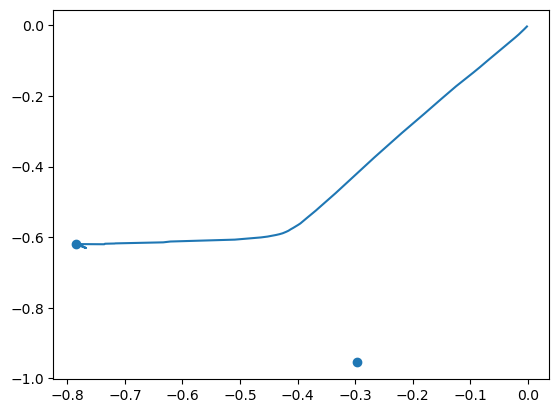

In [5]:
params = Parameters(n_steps=3000, n_spins=30, n_targets=2, T=0.2, nu=0.5, r_eat=1, r_detect=10, v=0.01, init_target_method="random_circle")
inst = Instance(params)
inst.update()


In [6]:
params = Parameters(n_steps=2000, n_spins=30, n_targets=5, T=0.01, nu=0.2, r_eat=1, r_detect=10, v=0.1, init_target_method="unit_circle")
inst = Instance(params)
i = 0

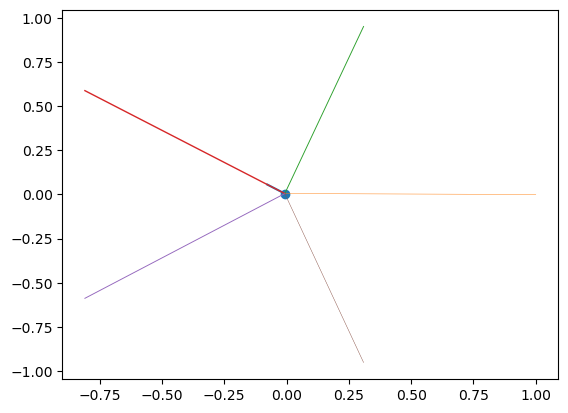

In [7]:
i = inst.one_steps(i)

In [8]:
start_pos = 0+0j
N = 30
T = 1 # neural noise
nu = 0.7
n_targets = 5
targets = np.random.randn(n_targets,1) + 1.j*np.random.randn(n_targets,1)
n_steps = 100
v0 = 0.1

agent = Agent(start_pos, n_steps, N, n_targets, targets, T, nu, v0)
agent.run_sim()

TypeError: Agent.__init__() takes 7 positional arguments but 9 were given

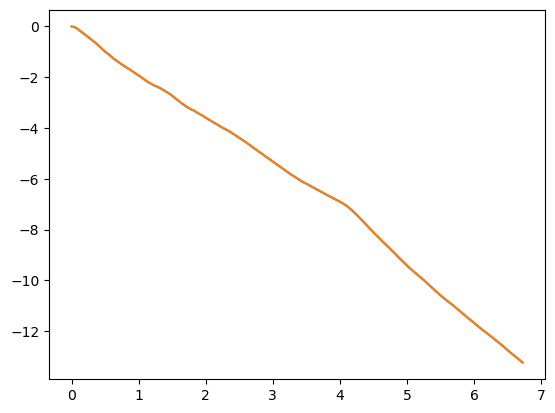

In [23]:
plt.plot(agent.pos_hist.real, agent.pos_hist.imag)

### Working out

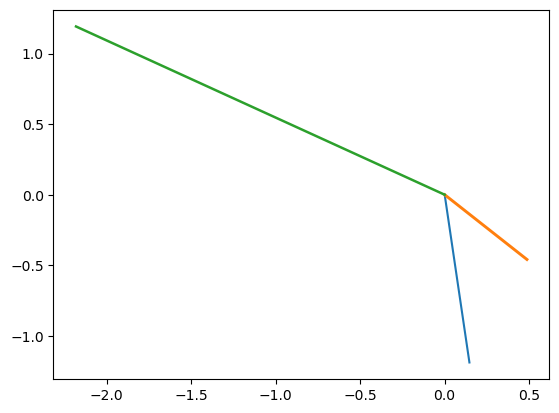

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
init time: 0.15253973007202148, simulation time: 0.26569175720214844


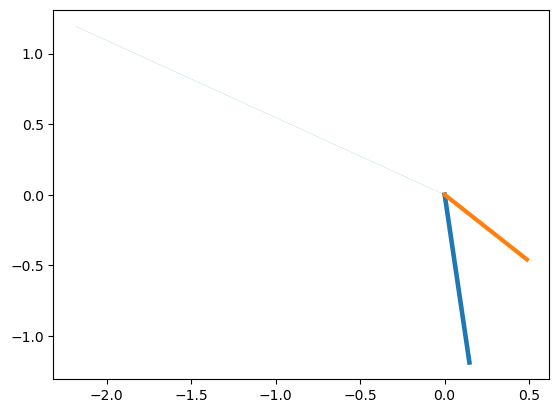

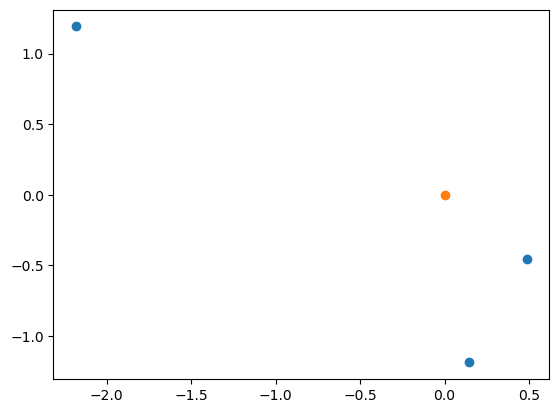

In [153]:


def init(num_s, num_t, nu):
    spin_population = np.random.randint(0, 2, (num_s, 1))

    # target_vectors = np.array([[1+0j], [-1-1j], [1+1j]])
    target_vectors = np.random.randn(num_t,1) + 1.j*np.random.randn(num_t,1)
    spin_targets = np.sort(np.array([np.mod(i, num_t) for i in range(len(spin_population))]))

    J = np.array([[ np.angle(target_vectors[p2].squeeze()) - np.angle(target_vectors[p1].squeeze()) for p2 in spin_targets] for p1 in spin_targets])
    J = np.minimum(np.absolute(J), 2*np.pi - np.absolute(J))
    J = np.cos(np.pi*(J/np.pi)**nu)
    return spin_population, target_vectors, spin_targets, J

# Each spin is given a target an can be turned on or off
def print_step(curr_spins, J, T):
    # minimize energy of the hamiltonian
    delta_spin = np.matmul(curr_spins,curr_spins.T)
    H = -num_targets/N *np.sum(J[delta_spin != 0])
    print(f"H={H}")

    # 1. pick a random spin and flip it
    print(curr_spins.squeeze())
    flip_idx = np.random.randint(0, len(curr_spins))
    curr_spins[flip_idx] = not curr_spins[flip_idx]
    print(curr_spins.squeeze())

    # 2. calculate the energy difference
    delta_spins = np.matmul(curr_spins,curr_spins.T)
    H_flipped = -num_targets/N *np.sum(J[delta_spins != 0])
    print(f"H_flipped={H_flipped}")
    delta_H = H_flipped - H
    print(f"delta_H:{delta_H}")
 
    # 3. if energy is lower than before, keep the flip, else keep it with probability exp(-DH/T)
    if delta_H >= 0:
        if np.random.rand() >= np.exp(-delta_H/T):
            # flip back
            print("flip back")
            curr_spins[flip_idx] = not curr_spins[flip_idx]
    print(curr_spins.squeeze())
    return curr_spins

def flip(curr_spins, J, T, n_targets):
    # minimize energy of the hamiltonian
    delta_spin = np.matmul(curr_spins,curr_spins.T)
    H = -n_targets/N *np.sum(J[delta_spin != 0])

    # 1. pick a random spin and flip it
    flip_idx = np.random.randint(0, len(curr_spins))
    curr_spins[flip_idx] = not curr_spins[flip_idx]

    # 2. calculate the energy difference
    delta_spins = np.matmul(curr_spins,curr_spins.T)
    H_flipped = -n_targets/N *np.sum(J[delta_spins != 0])
    delta_H = H_flipped - H

    # 3. if energy is lower than before, keep the flip, else keep it with probability exp(-DH/T)
    if delta_H >= 0:
        if np.random.rand() >= np.exp(-delta_H/T):
            # flip back
            curr_spins[flip_idx] = not curr_spins[flip_idx]
    return curr_spins


def run_sim(n_spins, n_targets, n_steps, T, nu, start_pos, v0):
    start_time = time.time()
    #init 
    spins, target_vectors, spin_targets, J = init(n_spins, n_targets, nu)
    draw_target(spins, spin_targets, target_vectors)
    init_time = time.time() - start_time
    for i in range(n_steps):
        # update spins
        spins = flip(spins, J, T, n_targets)

        # update position
            # move in direction of spins

            # update target vectors and J
    sim_time = time.time() - start_time
    print(spins.squeeze())

    print(f"init time: {init_time}, simulation time: {sim_time}")
    draw_target(spins, spin_targets, target_vectors)
    

    return target_vectors, spins


start_pos = np.array([0,0])
N = 100
T = 1 # neural noise
nu = 1
n_targets = 3
n_steps = 1000

target_vectors, spins = run_sim(N, n_targets, n_steps, T, nu )

plt.scatter(target_vectors.real, target_vectors.imag)
plt.scatter([0], [0])